In [20]:
import json
import pandas as pd 
import datetime
import numpy as np
from pycountry_convert import convert_country_alpha2_to_continent
from data_handling import utc_convert
import matplotlib.dates as mdates
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

pd.options.display.max_colwidth = 201

In [2]:
# CLustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_samples, fowlkes_mallows_score, \
                            confusion_matrix, make_scorer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from marvin_algorithms import purity_score

In [3]:
seed = 1437

# Prep data

In [4]:
from marvin_data_prep import load_data, prepare_data, separate_os

In [5]:
#data mining
from marvin_auxiliary_functions import timestamp_array, make_screen_vector, extract_interaction_sequence_selected_screen, \
                                       in_list,count_screen_in_sessions_data,distribution_cluster_result,build_overall_vector,\
                                       extract_orientation_selected_screen
from marvin_plot_functions import plot_confusion_matrix, plot_screen_timestamp_histogram_9, plot_screen_period_characteristics,\
                                  plot_screen_coordinates
from marvin_algorithms import dynamic_time_warp, condensed_matrix, distance_matrix, cross_distance_matrix, levenshtein
from useful_lists import important_screens, LIST_OF_SCREENS, ios_screens, ios_useful_screens, \
                            columns_name_quantization, columns_name_features

In [6]:
df = load_data('anonymisedapp', 150)
df = prepare_data(df, 'anonymisedapp')
df = separate_os(df)
print(len(df))

16143


In [152]:
df.heatmap_timeline[1]

[{'an': 'UploadViewController',
  'at': 0,
  'cor': [[-999, -999, 1, 10, 1, 0.57535099983215, []],
   [96,
    622,
    1,
    11,
    1,
    0.5772830247879,
    [[1, 0.57728797197342, 96, 622],
     [2, 0.59333444145159, 100, 620.5],
     [2, 0.60992094146786, 102, 620.5],
     [2, 0.62658406645642, 104, 621],
     [2, 0.64329598311451, 105.5, 625.5],
     [3, 0.65976331644924, 107.5, 632.5]]],
   [96, 622, 1, 0, 1, 0.65069699287415, []]],
  'ref': 'Launch',
  'vt': 1.1993860006332,
  'wb': False},
 {'an': 'PhotoStreamViewController',
  'at': 1.1993860006332,
  'cor': [[354.5,
    38.5,
    1,
    11,
    1,
    1.4530860185623,
    [[1, 1.4530910253525, 354.5, 38.5],
     [2, 1.4698099352245, 354.5, 38.5],
     [2, 1.5031310602208, 354.5, 38.5],
     [2, 1.5197960602236, 354.5, 38.5],
     [3, 1.5349310602469, 354.5, 38.5]]],
   [354.5, 38.5, 1, 0, 1, 1.5336319804192, []],
   [323.5, 299.5, 1, 3, 1, 3.4757409691811, []],
   [323.5,
    299.5,
    1,
    11,
    1,
    3.335969984531

In [8]:
df.screen_number.describe()

count    16143.000000
mean         4.905965
std          6.209389
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         99.000000
Name: screen_number, dtype: float64

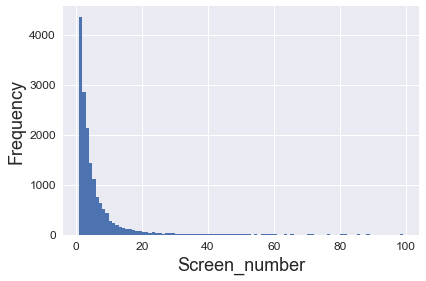

In [31]:
plt.hist(df.screen_number, bins = np.linspace(1,max(df.screen_number),max(df.screen_number)))
plt.xlabel('Screen_number', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

In [14]:
np.percentile(df.screen_number, 90)

11.0

In [15]:
df.interaction_number.describe()

count    16143.000000
mean        38.009540
std         60.446574
min          1.000000
25%          8.000000
50%         19.000000
75%         45.000000
max       2928.000000
Name: interaction_number, dtype: float64

In [16]:
np.percentile(df.interaction_number, 90)

92.0

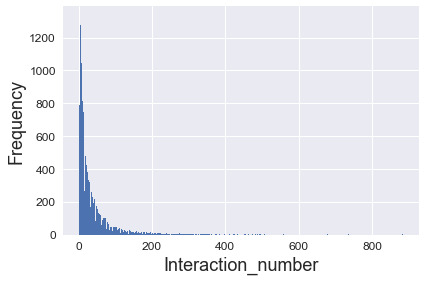

In [32]:
plt.hist(df.interaction_number[df.interaction_number < 1000], bins = 500)
plt.ylabel('Frequency')
plt.xlabel('Interaction_number', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

In [33]:
df.total_time.describe()

count    16143.000000
mean        83.837081
std        152.927423
min          1.000000
25%         17.000000
50%         43.000000
75%        101.000000
max       6840.000000
Name: total_time, dtype: float64

In [35]:
np.percentile(df.total_time, 90)

196.0

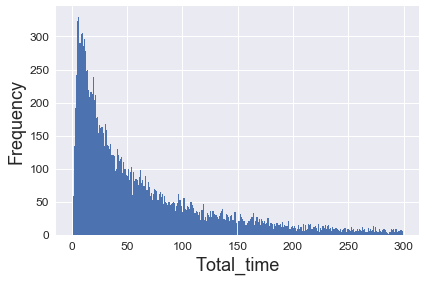

In [39]:
plt.hist(df.total_time[df.total_time < 300], bins = 300)
plt.ylabel('Frequency')
plt.xlabel('Total_time', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

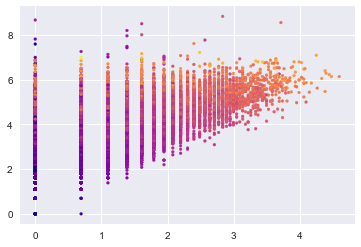

In [55]:
#fig = plt.figure(figsize = [9,5])
plt.scatter(x=np.log(df.screen_number), y=np.log(df.total_time), c=np.log(df.interaction_number), cmap='plasma', s=8)
#plt.xlabel('screen_number', fontsize = 14 )
#plt.ylabel('total_time', fontsize = 14)
#plt.text(120,6.6,'log_interaction_number', rotation=90, fontsize = 14)
#plt.colorbar()

In [50]:
np.corrcoef(df.total_time, df.screen_number, df)

array([[ 1.        ,  0.40765376],
       [ 0.40765376,  1.        ]])

In [65]:
a = df.country_name.value_counts().values / (len(df) / 100.)
a.round(2)

array([  4.08900000e+01,   1.79800000e+01,   1.30000000e+01,
         8.42000000e+00,   7.62000000e+00,   3.00000000e+00,
         1.89000000e+00,   1.88000000e+00,   1.83000000e+00,
         1.72000000e+00,   4.80000000e-01,   2.70000000e-01,
         2.20000000e-01,   1.20000000e-01,   1.10000000e-01,
         1.00000000e-01,   1.00000000e-01,   1.00000000e-01,
         5.00000000e-02,   3.00000000e-02,   3.00000000e-02,
         3.00000000e-02,   2.00000000e-02,   2.00000000e-02,
         2.00000000e-02,   2.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02])

In [66]:
df.country_name.value_counts()

Denmark                 6601
Germany                 2902
Australia               2098
United States           1360
Sweden                  1230
Switzerland              484
Netherlands              305
Canada                   303
Austria                  295
United Kingdom           278
Luxembourg                77
Norway                    43
Italy                     35
Thailand                  19
Unknown                   17
Greece                    16
Finland                   16
Singapore                 16
Portugal                   8
France                     5
Belgium                    5
Spain                      5
Jamaica                    4
India                      4
United Arab Emirates       4
Iceland                    3
South Africa               2
Latvia                     2
Turkey                     1
Faroe Islands              1
Japan                      1
Mexico                     1
Taiwan                     1
Czech Republic             1
Name: country_

In [68]:
df.device_model_name.value_counts()

iPhone 6                4350
iPhone 6s               3767
iPhone 7                2417
iPhone 5s               1655
iPhone 6SE              1089
iPhone 7 Plus            825
iPhone 6s Plus           472
iPhone 5                 465
iPhone 6 Plus            428
iPhone 5c                187
iPhone 4s                144
iPad Air 2               105
iPad 4                    53
iPad Air                  52
iPad mini 2               31
iPad Mini                 25
iPad2                     17
iPad 3                    15
iPad Pro (9.7 inch)       13
iPhone Simulator          10
iPad Pro (12.9 inch)       7
iPad mini 4                7
iPod Touch 6G              5
iPod Touch 5G              2
iPad mini 3                2
Name: device_model_name, dtype: int64

In [69]:
df.device_model_name.value_counts().values / (len(df) / 100.)

array([  2.69466642e+01,   2.33351917e+01,   1.49724339e+01,
         1.02521217e+01,   6.74595800e+00,   5.11057424e+00,
         2.92386793e+00,   2.88050548e+00,   2.65130397e+00,
         1.15839683e+00,   8.92027504e-01,   6.50436722e-01,
         3.28315679e-01,   3.22121043e-01,   1.92033699e-01,
         1.54865886e-01,   1.05308803e-01,   9.29195317e-02,
         8.05302608e-02,   6.19463545e-02,   4.33624481e-02,
         4.33624481e-02,   3.09731772e-02,   1.23892709e-02,
         1.23892709e-02])

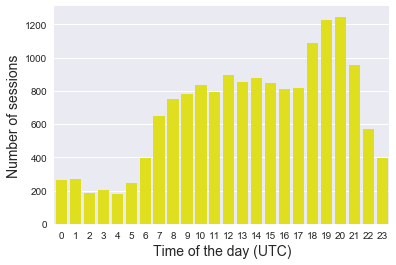

In [72]:
sns.barplot(data=df, y='total_time', x='time_of_the_day', estimator=len, color ='yellow')
ax=plt.gca()
ax.set_xlabel('Time of the day (UTC)', fontsize=14)
ax.set_ylabel('Number of sessions', fontsize=14)

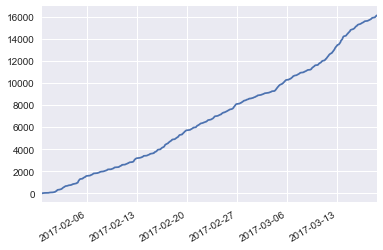

In [73]:
pd.Series(index=[np.sort(df['time_formatted'])], data=range(len(df))).plot(label='sessions')
ax=plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

In [78]:
df_day = df[['ymd', 'heatmap_timeline']].groupby('ymd').count()

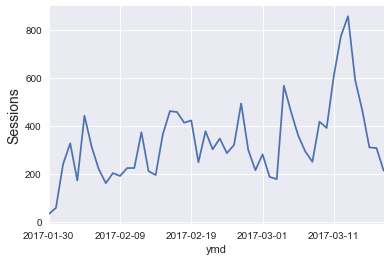

In [96]:
df_day.plot()
ax=plt.gca()
ax.set_ylabel('Sessions', fontsize =14)
ax.legend([])

In [98]:
df.app_version.value_counts()

1.5 (1702171140)    9749
1.3 (1701312221)    4995
1.4 (1702161135)    1110
1.3 (1702152310)     150
1.2 (1701301632)      52
1.2 (1701311441)      39
1.3 (1702141609)      20
1.3 (1702131651)      20
1.3 (1701311441)       6
1.4 (1702152310)       2
Name: app_version, dtype: int64

In [141]:
df_day_ver = df[['ymd','app_version', 'heatmap_timeline']].groupby(['ymd','app_version']).count().unstack('app_version').fillna(0)

In [143]:
df_day_ver.head(3)

heatmap_timeline                                    \
app_version 1.2 (1701301632) 1.2 (1701311441) 1.3 (1701311441)   
ymd                                                              
2017-01-30              34.0              0.0              0.0   
2017-01-31              18.0             32.0              3.0   
2017-02-01               0.0              4.0              3.0   

                                                                \
app_version 1.3 (1701312221) 1.3 (1702131651) 1.3 (1702141609)   
ymd                                                              
2017-01-30               0.0              0.0              0.0   
2017-01-31               6.0              0.0              0.0   
2017-02-01             234.0              0.0              0.0   

                                                                \
app_version 1.3 (1702152310) 1.4 (1702152310) 1.4 (1702161135)   
ymd                                                              
2017-01-30               0.0              0.0              0.0   
2017-01-31               0.0              0.0              0.0   
2017-02-01               0.0              0.0              0.0   

                              
app_version 1.5 (1702171140)  
ymd                           
2017-01-30               0.0  
2017-01-31               0.0  
2017-02-01               0.0

In [138]:
df_day_ver.head(1)

heatmap_timeline                                    \
app_version 1.2 (1701301632) 1.2 (1701311441) 1.3 (1701311441)   
ymd                                                              
2017-01-30              34.0              0.0              0.0   

                                                                \
app_version 1.3 (1701312221) 1.3 (1702131651) 1.3 (1702141609)   
ymd                                                              
2017-01-30               0.0              0.0              0.0   

                                                                \
app_version 1.3 (1702152310) 1.4 (1702152310) 1.4 (1702161135)   
ymd                                                              
2017-01-30               0.0              0.0              0.0   

                              
app_version 1.5 (1702171140)  
ymd                           
2017-01-30               0.0

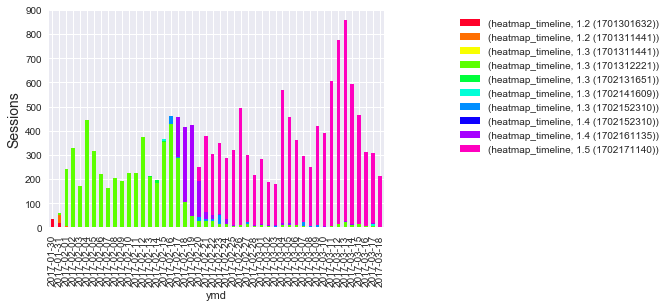

In [144]:
plt.figure(figsize=[13,9])
df_day_ver.plot(kind='bar',stacked=True, cmap='gist_rainbow')
ax=plt.gca()
ax.set_ylabel('Sessions', fontsize =14)
ax.legend(bbox_to_anchor=(1.2, 1))

# TESTING LARGER DATASET DIVIDED INTO SCREENS

In [7]:
df_seq = extract_interaction_sequence_selected_screen(df, selected_screens=ios_useful_screens, coor_details=True)
# df_seq['hist_length'] = df_seq.interaction_hist.apply(len)
# df_seq['interaction_number'] = df_seq.interaction_hist.apply(sum)
len(df_seq)

48002

In [8]:
# Remove rows when there is non_portrait interaction based on index of df_ori
df_ori = extract_orientation_selected_screen(df, selected_screens=ios_useful_screens)
df_ori['non_portrait'] = df_ori['orientation_list'].apply(in_list, list_of_items = [0,2,3])
index_non_portrait = df_ori[df_ori.non_portrait != 0].index

df_seq.drop(index_non_portrait, inplace=True)
len(df_seq)

47999

In [9]:
df_seq['interaction_vector'] = 0.
df_seq.loc[:,'interaction_vector'] = df_seq.apply(build_overall_vector, axis=1) # important

In [37]:
df_seq.head(7)

,session_id,user_id,time,screen,interaction_hist,interaction_label,interaction_coors_binned,view_time,interaction_vector
0,588f6d9cc4b502ffffb26f48,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:47:13,CouponModalViewController,"[4, 2, 0, 1, 1]","[2.0, 2.0, 0.0]","[4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]",2.708618,"[4, 2, 0, 1, 1, 2.0, 2.0, 0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.7086179852486]"
1,588f6d9cc4b502ffffb26f48,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:47:13,PhotoStreamViewController,"[23, 10, 9, 0, 4]","[3.0, 20.0, 0.0]","[40.0, 2.0, 1.0, 0.0, 0.0, 2.0, 14.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0]",44.405760,"[23, 10, 9, 0, 4, 3.0, 20.0, 0.0, 40.0, 2.0, 1.0, 0.0, 0.0, 2.0, 14.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 44.405759990215]"
2,588f6d9cc4b502ffffb26f48,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:47:13,PurchaseViewController,"[2, 0, 0, 1, 1]","[1.0, 1.0, 0.0]","[2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2.268834,"[2, 0, 0, 1, 1, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.2688339948654]"
3,588f6d9cc4b502ffffb26f48,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:47:13,UploadViewController,"[3, 0, 2, 1, 0]","[1.0, 1.0, 1.0]","[4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.199386,"[3, 0, 2, 1, 0, 1.0, 1.0, 1.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1993860006332]"
4,588f6e26ff6059ffff8b4595,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:49:31,EventPageViewController,"[10, 1, 2, 0, 7]","[3.0, 7.0, 0.0]","[14.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 5.0, 0.0, 0.0, 0.0, 0.0]",13.035012,"[10, 1, 2, 0, 7, 3.0, 7.0, 0.0, 14.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 5.0, 0.0, 0.0, 0.0, 0.0, 13.03501200676]"
5,588f6e26ff6059ffff8b4595,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:49:31,EventPageViewController,"[3, 1, 0, 0, 2]","[1.0, 2.0, 0.0]","[4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2.825832,"[3, 1, 0, 0, 2, 1.0, 2.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.8258320093155]"
6,588f6e26ff6059ffff8b4595,6c705f66cbf05fe658f46f286aea07f5,2017-01-30 16:49:31,PhotoStreamViewController,"[4, 0, 2, 0, 2]","[2.0, 2.0, 0.0]","[4.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4.840688,"[4, 0, 2, 0, 2, 2.0, 2.0, 0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.8406879901886]"


In [10]:
df_quan = pd.DataFrame(df_seq['interaction_vector'].tolist(), columns = columns_name_quantization, index=df_seq.index)
df_vq = pd.concat([df_seq[['session_id','user_id','time','screen']], df_quan], axis=1)
# important
df_vq['log_interactionnumber'] = np.log(df_vq.interaction_number)
df_vq['log_viewtime'] = np.log(df_vq.viewtime)
len(df_vq)

47999

In [23]:
df_vq.screen.value_counts().sort_values(ascending=False).head(6)

EventPageViewController             10353
GuestsViewController                 5606
UploadViewController                 4256
ProfileViewController                3881
PhotoStreamViewController            3215
CreateProfileModalViewController     3022
Name: screen, dtype: int64

In [162]:
df_vq.viewtime.describe()

count    47999.000000
mean        13.865971
std         46.856826
min          0.046163
25%          2.477868
50%          5.356115
75%         13.109324
max       4852.956295
Name: viewtime, dtype: float64

In [13]:
np.percentile(df_vq.viewtime, 90)

31.708917796612049

In [15]:
df_vq.hist1.describe()

count    47999.000000
mean         5.820975
std          9.585471
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        452.000000
Name: hist1, dtype: float64

In [16]:
np.percentile(df_vq.hist1, 90)

12.0

** Note: No need for these steps when quantizing with equal bins **

In [126]:
# Remove short and long sequence
df_seq = df_seq[(df_seq.hist_length > 1) & (df_seq.hist_length < 200) & (df_seq.interaction_number > 1)]
# Period < 3 second is likely to be user mistake, and not worth considering
len(df_seq)

16489

In [127]:
# extra calculations
df_seq['interaction_hist_normalized'] = df_seq['interaction_hist'] / df_seq['interaction_number']
df_seq['swipe'] = df_seq['interaction_label'].apply(in_list, list_of_items = ['trail','swipe_up','swipe_down',
                                                                                     'swipe_right','swipe_left'])
df_seq['tap'] = df_seq['interaction_label'].apply(in_list, list_of_items = ['single_tap','double_tap'])
df_seq['swipe/tap ratio'] = df_seq['swipe'] / df_seq['tap']
df_seq['interaction/length ratio'] = df_seq['interaction_number'] / df_seq['hist_length']

In [128]:
df_seq['log_hist_length'] = np.log(df_seq.hist_length)
df_seq['log_interaction_number'] = np.log(df_seq.interaction_number)

### Plot scatter plot different screens

In [18]:
df_ss = pd.pivot_table(df_vq[['screen','hist1','viewtime']], index=['screen'], aggfunc=np.mean)
df_ss

,hist1,viewtime
screen,,
AboutViewController,3.624060,9.494077
AdminViewController,2.863636,4.992283
CameraViewController,3.413545,10.711005
CommentViewController,12.893617,28.817217
CouponModalViewController,3.942920,9.264714
CreateProfileEmailViewController,10.163948,31.886875
CreateProfileModalViewController,4.616810,18.259873
CreateWeddingViewController,14.560491,30.643550
DownloadViewController,2.995708,6.197723


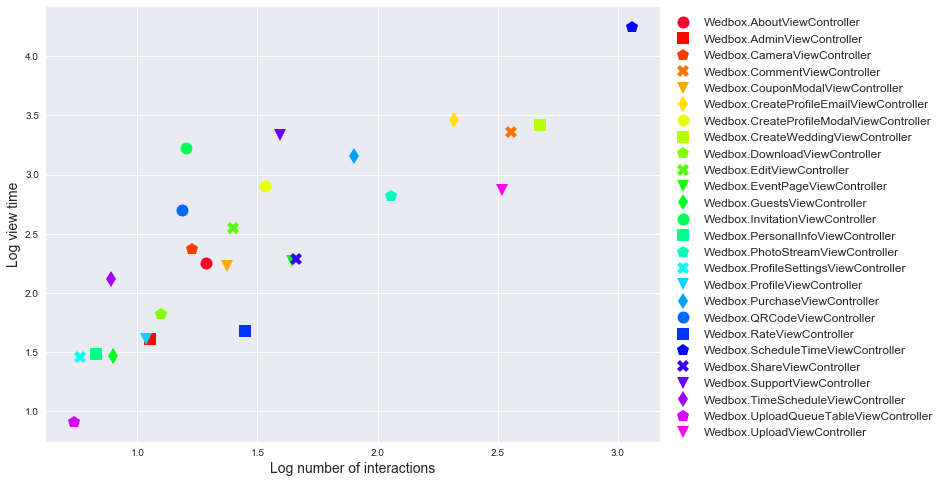

In [22]:
# Plot
from cycler import cycler
fig, ax = plt.subplots(figsize=[11,8])
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(cycler('color', [cm(1.*i/len(df_ss)) for i in range(len(df_ss))]) + 
                  cycler('marker', ['o','s','p','X','v','d','o','s','p','X','v','d',
                                    'o','s','p','X','v','d','o','s','p','X','v','d',
                                    'p','v']))

i = 0
for index, row in df_ss.iterrows():
    ax.plot(np.log(row.hist1), np.log(row.viewtime), linestyle='', ms=12, label=index)
    i += 1
ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
ax.set_xlabel('Log number of interactions', fontsize=14)
ax.set_ylabel('Log view time', fontsize=14)

### Testing on all users, 4 different screens

**Randomly choose 4 equal groups of screens from df_vq:**

In [11]:
number_row = 3000
df_1 = df_vq[df_vq.screen == 'PhotoStreamViewController'].sample(n=number_row, random_state=seed)
df_2 = df_vq[df_vq.screen == 'UploadViewController'].sample(n=number_row, random_state=seed)
df_4 = df_vq[df_vq.screen == 'EventPageViewController'].sample(n=number_row, random_state=seed)
df_3 = df_vq[df_vq.screen == 'GuestsViewController'].sample(n=number_row, random_state=seed)
df_sample = pd.concat([df_1, df_2, df_3, df_4])
len(df_sample)

12000

## *IMPORTANT: Clear df out of memory*

In [12]:
del df
del df_seq
del df_vq

## LABEL ENCODING y true. important

In [13]:
y = df_sample['screen']
le = LabelEncoder()
y_true = le.fit_transform(y)
y_true.shape

(12000,)

In [15]:
le.classes_

array(['EventPageViewController', 'GuestsViewController',
       'PhotoStreamViewController', 'UploadViewController'], dtype=object)

In [23]:
df_sample

,session_id,user_id,time,screen,hist1,hist4_1,hist4_2,hist4_3,hist4_4,tap,...,bin_tap_4,bin_swipe_1,bin_swipe_2,bin_swipe_3,bin_swipe_4,bin_other_1,bin_other_2,bin_other_3,bin_other_4,viewtime
11067,58a21569c4b502ffffce69ef,a3c96f00d145e987338a9d71b1868709,2017-02-13 20:22:28,PhotoStreamViewController,2.0,0.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.116772
11481,58a2e206c4b502ffff64ebef,49a5daf57e82212e26db9535d15c8708,2017-02-14 11:01:03,PhotoStreamViewController,4.0,0.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.131687
29920,58bb6bc9c4b502ffff8eaec4,2763caa26c539cec3430e4091a900992,2017-03-05 01:38:09,PhotoStreamViewController,2.0,0.0,0.0,0.0,2.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.935146
10971,58a20baeff6059ffff8b4669,cb194dec3dd140e0de556a35276e6a0f,2017-02-13 19:42:16,PhotoStreamViewController,4.0,2.0,0.0,0.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.667923
25032,58b317aeff6059ffff8b456b,55d2bff0576f4bb7b482540a5acc5669,2017-02-26 18:02:12,PhotoStreamViewController,2.0,0.0,0.0,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.427660
8818,589eec45c4b502ffff21aae4,9de7ea059318bcc0bf5e6fe9aa6dcd22,2017-02-11 10:52:47,PhotoStreamViewController,5.0,0.0,0.0,3.0,2.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,20.846188
22760,58b0756ec4b502ffff14b377,3d68cf22b49aaa7f7b49eece872d6a85,2017-02-24 18:09:59,PhotoStreamViewController,2.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.771109
22162,58af4dd0c4b502ffff15116f,1765eef1a9fa832b8c68af6cb8da249c,2017-02-23 21:04:33,PhotoStreamViewController,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.736294
15029,58a6c86bc4b502ffffcc4295,0a0c7e4687c76c0badd82fc9eb1570a4,2017-02-17 09:57:24,PhotoStreamViewController,5.0,2.0,0.0,1.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.117363
13766,58a5c89cc4b502ffffa3ccec,c9add4aeb121bebaa9d9ab2671ee14f3,2017-02-16 15:46:36,PhotoStreamViewController,7.0,2.0,1.0,2.0,2.0,3.0,...,2.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,6.725373


# EXPERIMENT ON DESCRIPTIVE STATS

In [44]:
df_vq['swipe/tap ratio'] = df_vq['swipe'] / df_vq['tap']  # no need anymore
df_vq['interaction/length ratio'] = df_vq['hist1'] / df_vq['viewtime']

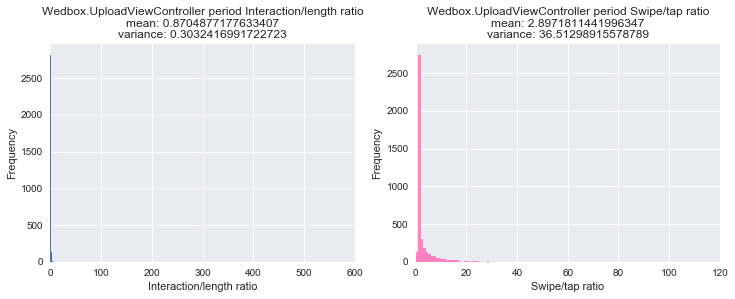

In [48]:
plot_screen_period_characteristics(df_vq, 'UploadViewController', [0,600], [0,120], 'ratio')

In [34]:
XX = df_sample[['interaction_number', 'viewtime','tap','swipe']]

Confusion matrix, without normalization
Scores:
Purity: 0.28967
AMI: 0.02208
Rand Index: 0.00528
Fowlkes–Mallows index: 0.46773


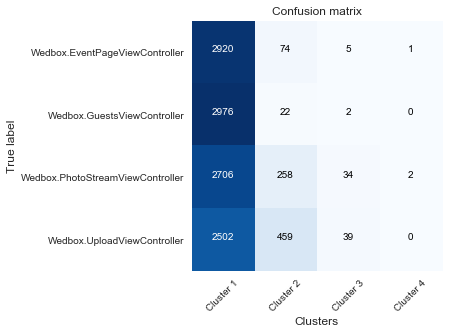

In [35]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(XX) # 4 features
yy_cluster = kmeans.labels_
plot_confusion_matrix(y_true, yy_cluster,classes=le.classes_)

In [19]:
XX_scale = df_sample[['log_interactionnumber','log_viewtime','tap','swipe']]
scaler = MinMaxScaler()
XX_scale = scaler.fit_transform(XX_scale)

Confusion matrix, without normalization
Scores:
Purity: 0.43125
AMI: 0.11613
Rand Index: 0.10177
Fowlkes–Mallows index: 0.35120


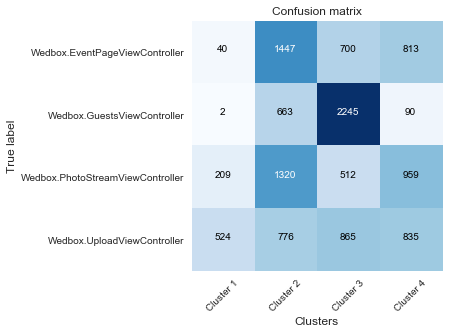

In [32]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(XX_scale) # 4 features
yy_cluster = kmeans.labels_
plot_confusion_matrix(y_true, yy_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.39750
AMI: 0.09097
Rand Index: 0.09164
Fowlkes–Mallows index: 0.35725


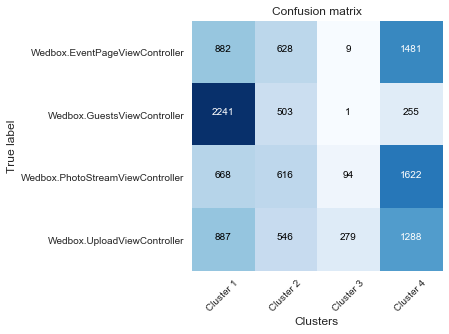

In [33]:
spectre = SpectralClustering(n_clusters=4, gamma = 1.0, affinity = 'rbf', random_state=seed, ).fit(XX_scale)
y_cluster = spectre.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

### comparison plot

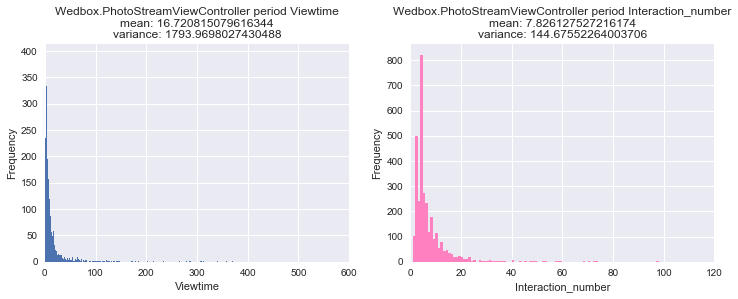

In [26]:
plot_screen_period_characteristics(df_vq, 'PhotoStreamViewController', [0,600], [0,120])

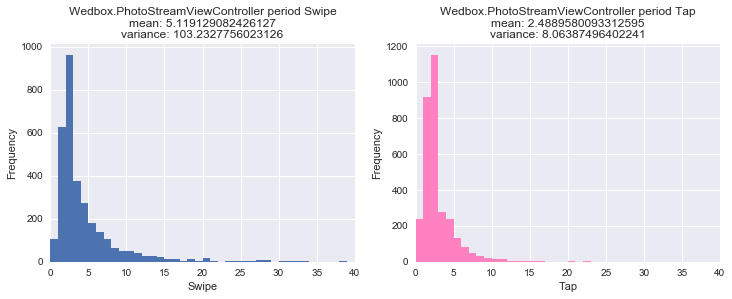

In [40]:
plot_screen_period_characteristics(df_vq, 'PhotoStreamViewController',[0,40], [0,40],type = 'swipe-tap')

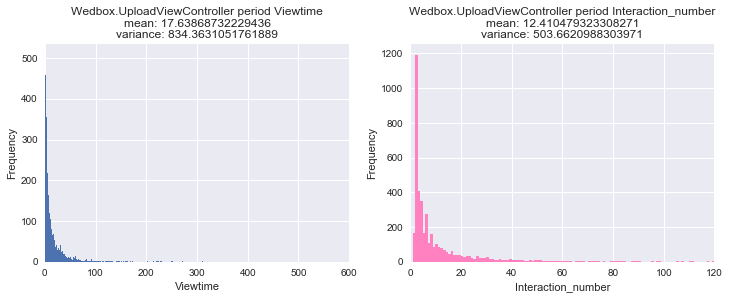

In [28]:
plot_screen_period_characteristics(df_vq, 'UploadViewController', [0,600], [0,120])

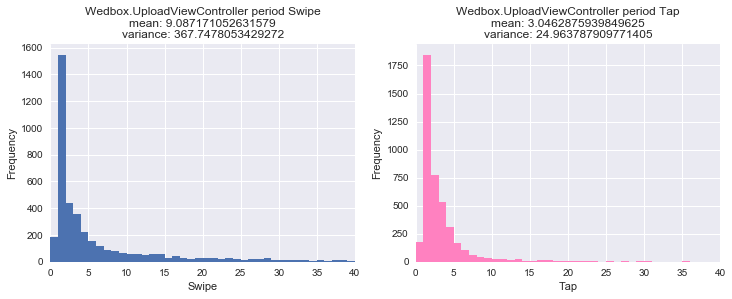

In [39]:
plot_screen_period_characteristics(df_vq, 'UploadViewController',[0,40], [0,40],type = 'swipe-tap')

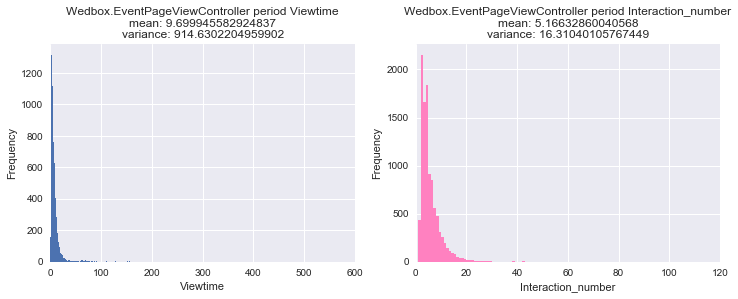

In [30]:
plot_screen_period_characteristics(df_vq, 'EventPageViewController', [0,600], [0,120])

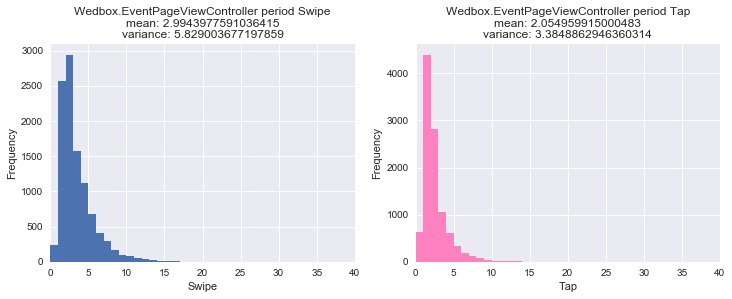

In [36]:
plot_screen_period_characteristics(df_vq, 'EventPageViewController',[0,40], [0,40],type = 'swipe-tap')

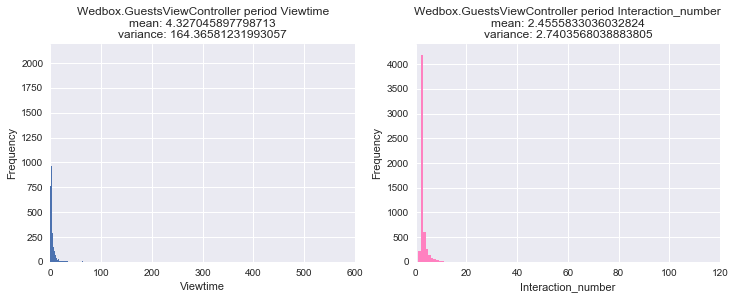

In [37]:
plot_screen_period_characteristics(df_vq, 'GuestsViewController', [0,600], [0,120])

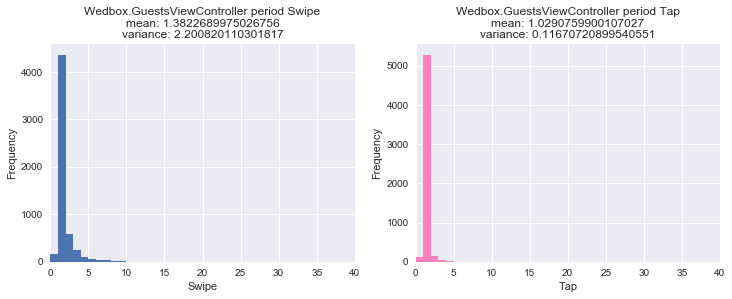

In [38]:
plot_screen_period_characteristics(df_vq, 'GuestsViewController',[0,40], [0,40],type = 'swipe-tap')

### coordinate plots

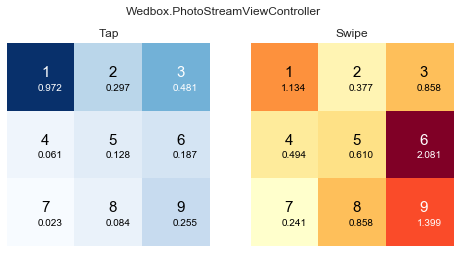

In [30]:
plot_screen_coordinates(df_vq, 'PhotoStreamViewController', bin=9)

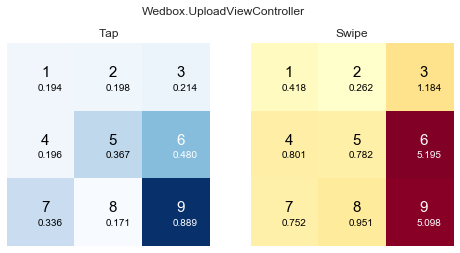

In [31]:
plot_screen_coordinates(df_vq, 'UploadViewController', bin=9)

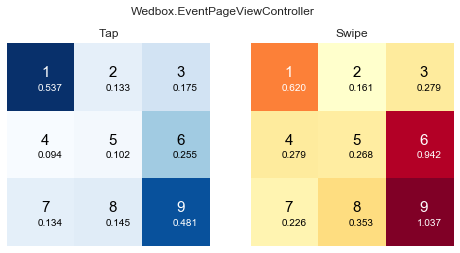

In [32]:
plot_screen_coordinates(df_vq, 'EventPageViewController', bin=9)

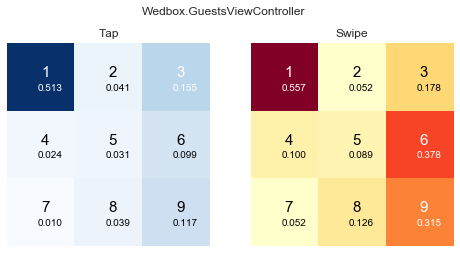

In [33]:
plot_screen_coordinates(df_vq, 'GuestsViewController', bin=9)

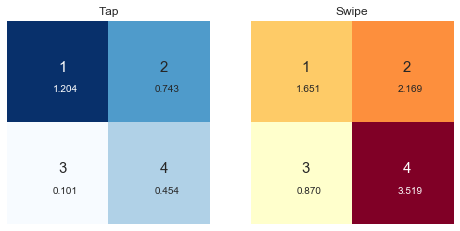

In [156]:
plot_screen_coordinates(df_vq, 'PhotoStreamViewController')

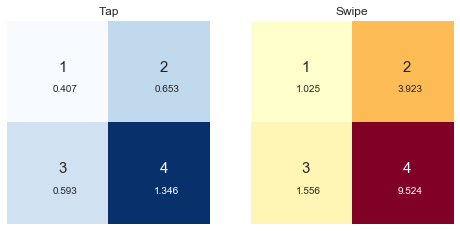

In [157]:
plot_screen_coordinates(df_sample, 'UploadViewController')

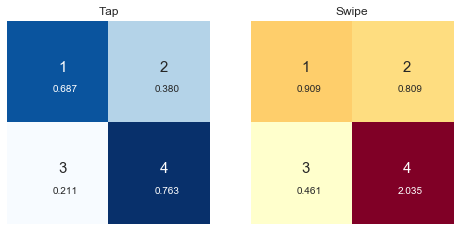

In [158]:
plot_screen_coordinates(df_sample, 'EventPageViewController')

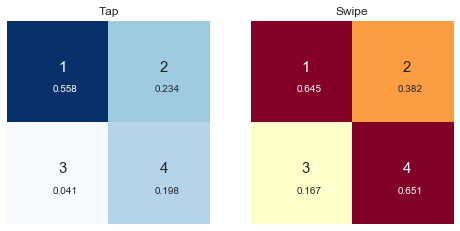

In [159]:
plot_screen_coordinates(df_sample, 'GuestsViewController')

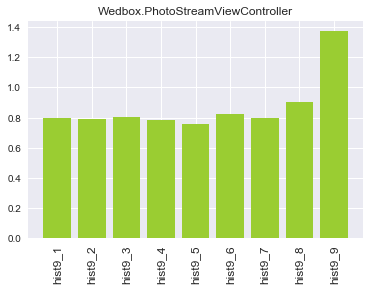

In [23]:
plot_screen_timestamp_histogram_9(df_vq, 'PhotoStreamViewController')

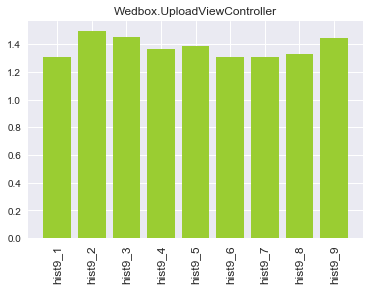

In [25]:
plot_screen_timestamp_histogram_9(df_vq, 'UploadViewController')

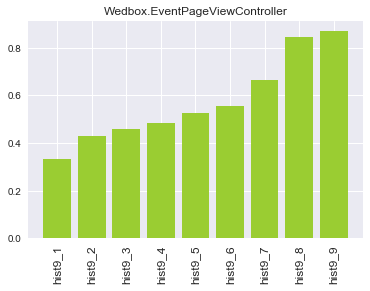

In [26]:
plot_screen_timestamp_histogram_9(df_vq, 'EventPageViewController')

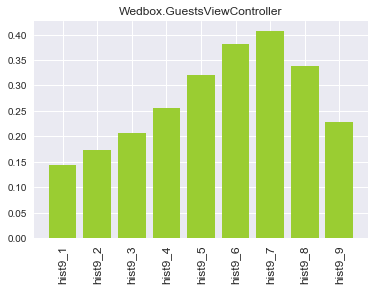

In [27]:
plot_screen_timestamp_histogram_9(df_vq, 'GuestsViewController')

## *Attention: New approach with equal bins*

In [21]:
columns_simple = ['hist4_1','hist4_2','hist4_3','hist4_4',
                  'bin1','bin4_tap_1','bin4_tap_2','bin4_tap_3','bin4_tap_4','bin4_swipe_1','bin4_swipe_2',
                  'bin4_swipe_3','bin4_swipe_4',
                  'log_interactionnumber','log_viewtime']
X = df_sample[columns_simple]

In [17]:
columns_name_4 = ['hist4_1','hist4_2','hist4_3','hist4_4','tap','swipe','other',
                  'bin1','bin4_tap_1','bin4_tap_2','bin4_tap_3','bin4_tap_4','bin4_swipe_1','bin4_swipe_2',
                  'bin4_swipe_3','bin4_swipe_4', 'bin4_other_1','bin4_other_2','bin4_other_3','bin4_other_4',
                  'log_interactionnumber','log_viewtime']
X = df_sample[columns_name_4]

In [54]:
columns_name_9 = ['hist9_1','hist9_2','hist9_3','hist9_4','hist9_5','hist9_6','hist9_7','hist9_8','hist9_9',
                  'tap','swipe','other','bin1', 'bin9_tap_1','bin9_tap_2','bin9_tap_3','bin9_tap_4','bin9_tap_5',
                  'bin9_tap_6', 'bin9_tap_7','bin9_tap_8','bin9_tap_9','bin9_swipe_1','bin9_swipe_2','bin9_swipe_3',
                  'bin9_swipe_4','bin9_swipe_5','bin9_swipe_6','bin9_swipe_7','bin9_swipe_8','bin9_swipe_9','bin9_other_1',
                  'bin9_other_2','bin9_other_3','bin9_other_4','bin9_other_5','bin9_other_6','bin9_other_7',
                  'bin9_other_8','bin9_other_9','log_interactionnumber','log_viewtime']
X = df_sample[columns_name_9]

In [59]:
columns_name_no_other = ['hist4_1','hist4_2','hist4_3','hist4_4','hist9_1','hist9_2','hist9_3','hist9_4','hist9_5','hist9_6',
                         'hist9_7','hist9_8','hist9_9','tap','swipe','bin1','bin4_tap_1','bin4_tap_2','bin4_tap_3','bin4_tap_4',
                         'bin4_swipe_1','bin4_swipe_2','bin4_swipe_3','bin4_swipe_4','bin9_tap_1','bin9_tap_2','bin9_tap_3',
                         'bin9_tap_4','bin9_tap_5','bin9_tap_6', 'bin9_tap_7','bin9_tap_8','bin9_tap_9','bin9_swipe_1',
                         'bin9_swipe_2','bin9_swipe_3','bin9_swipe_4','bin9_swipe_5','bin9_swipe_6','bin9_swipe_7',
                         'bin9_swipe_8','bin9_swipe_9','log_interactionnumber','log_viewtime']
X = df_sample[columns_name_no_other]

In [21]:
columns_name_everything = ['hist4_1','hist4_2','hist4_3','hist4_4','hist9_1','hist9_2','hist9_3','hist9_4','hist9_5','hist9_6',
                         'hist9_7','hist9_8','hist9_9','tap','swipe','other','bin1','bin4_tap_1','bin4_tap_2','bin4_tap_3',
                         'bin4_tap_4','bin4_swipe_1','bin4_swipe_2','bin4_swipe_3','bin4_swipe_4','bin4_other_1','bin4_other_2',
                         'bin4_other_3','bin4_other_4','bin9_tap_1','bin9_tap_2','bin9_tap_3','bin9_tap_4','bin9_tap_5',
                         'bin9_tap_6', 'bin9_tap_7','bin9_tap_8','bin9_tap_9','bin9_swipe_1',
                         'bin9_swipe_2','bin9_swipe_3','bin9_swipe_4','bin9_swipe_5','bin9_swipe_6','bin9_swipe_7',
                         'bin9_swipe_8','bin9_swipe_9','bin9_other_1',
                  'bin9_other_2','bin9_other_3','bin9_other_4','bin9_other_5','bin9_other_6','bin9_other_7',
                  'bin9_other_8','bin9_other_9','log_interactionnumber','log_viewtime']
X = df_sample[columns_name_everything]

### **ATTENTION**: Scale the data

In [22]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_scale.shape

(12000, 58)

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

In [40]:
lda = LatentDirichletAllocation(n_topics=20, random_state =seed)

In [41]:
lda.fit(X_scale)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=20, perp_tol=0.1,
             random_state=1437, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [43]:
lda.components_

array([[  5.00000041e-02,   5.00000031e-02,   5.00000033e-02, ...,
          5.00000025e-02,   5.00000029e-02,   5.00000029e-02],
       [  5.00000029e-02,   5.00000115e-02,   5.00000048e-02, ...,
          5.00000022e-02,   5.00004235e-02,   5.00006327e-02],
       [  5.00000373e-02,   5.00000242e-02,   5.00000110e-02, ...,
          5.00000024e-02,   5.00052687e-02,   5.00240568e-02],
       ..., 
       [  5.00000037e-02,   5.00000148e-02,   5.00000062e-02, ...,
          5.00000024e-02,   5.00021090e-02,   5.00048215e-02],
       [  8.87881002e+00,   1.19965293e+01,   5.46974346e+00, ...,
          5.00000024e-02,   1.66774169e+02,   2.87933970e+02],
       [  7.09312320e+00,   1.24501822e+01,   6.60085870e+00, ...,
          5.00000030e-02,   1.97006036e+02,   4.66418098e+02]])

### kmeans

Confusion matrix, without normalization
Scores:
Purity: 0.42808
AMI: 0.11196
Rand Index: 0.10511
Fowlkes–Mallows index: 0.36925


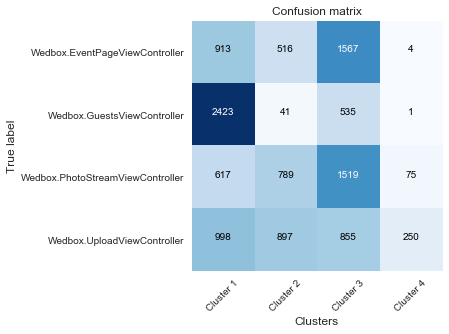

In [48]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(X_scale) # X simple
y_cluster = kmeans.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.42917
AMI: 0.11210
Rand Index: 0.10598
Fowlkes–Mallows index: 0.37131


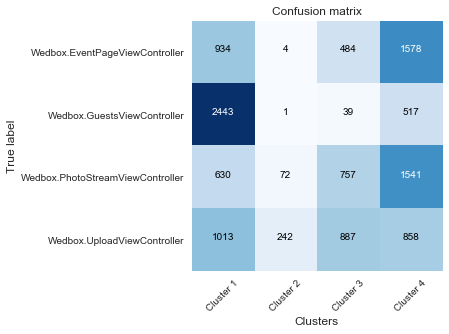

In [53]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(X_scale) # X 4
y_cluster = kmeans.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.42908
AMI: 0.11079
Rand Index: 0.10463
Fowlkes–Mallows index: 0.38341


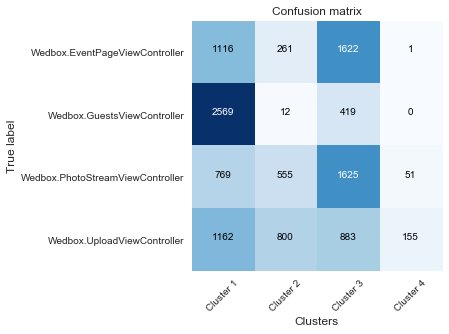

In [56]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(X_scale) # X 9
y_cluster = kmeans.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.43342
AMI: 0.11115
Rand Index: 0.10618
Fowlkes–Mallows index: 0.39098


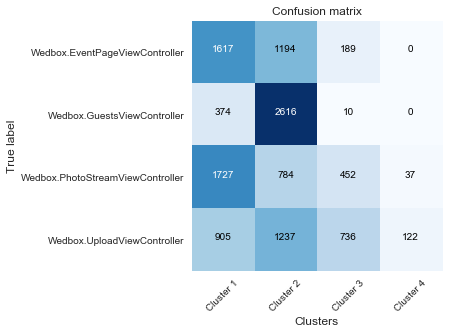

In [61]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(X_scale) # X no other
y_cluster = kmeans.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.43358
AMI: 0.11113
Rand Index: 0.10618
Fowlkes–Mallows index: 0.39073


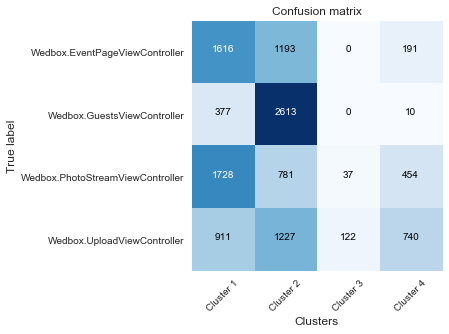

In [64]:
kmeans = KMeans(n_clusters=4, random_state=seed).fit(X_scale) # X everything
y_cluster = kmeans.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

## choose alogrithms

1
Confusion matrix, without normalization
Scores:
Purity: 0.43742
AMI: 0.11637
Rand Index: 0.09248
Fowlkes–Mallows index: 0.35766


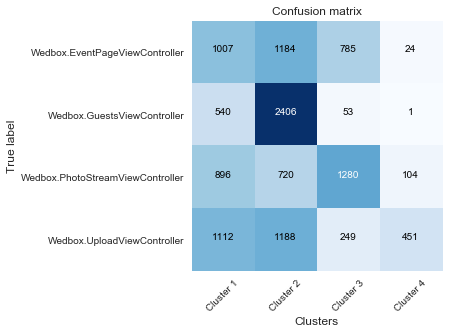

In [16]:
para = {'gamma' : [0.01, 0.1, 1, 10]}
y_c = []
best_ps = []
for g in para['gamma']:
    spectre = SpectralClustering(n_clusters=4, random_state=seed, gamma = g).fit(X_scale) # X simple
    y_cluster = spectre.labels_
    y_c.append(y_cluster)
    best_ps.append(purity_score(y_true, y_cluster))
    
i = best_ps.index(max(best_ps))
print(i)    
plot_confusion_matrix(y_true, y_c[i],classes=le.classes_)

1
Confusion matrix, without normalization
Scores:
Purity: 0.43742
AMI: 0.11637
Rand Index: 0.09248
Fowlkes–Mallows index: 0.35766


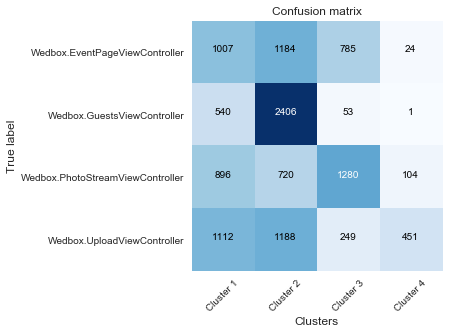

In [16]:
para = {'gamma' : [0.01, 0.1, 1, 10]}
y_c = []
best_ps = []
for g in para['gamma']:
    spectre = SpectralClustering(n_clusters=4, random_state=seed, gamma = g).fit(X_scale) # X simple
    y_cluster = spectre.labels_
    y_c.append(y_cluster)
    best_ps.append(purity_score(y_true, y_cluster))
    
i = best_ps.index(max(best_ps))
print(i)    
plot_confusion_matrix(y_true, y_c[i],classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.39767
NMI: 0.09390
Rand Index: 0.07741
Fowlkes–Mallows index: 0.34009


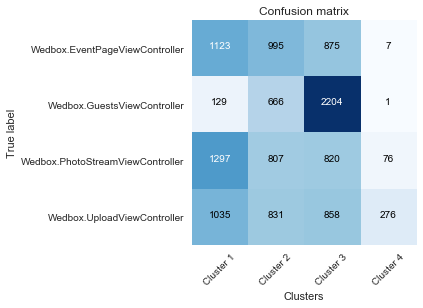

In [37]:
spectre = SpectralClustering(n_clusters=4, random_state=seed).fit(X_scale) # X 4
y_cluster = spectre.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.42000
NMI: 0.11713
Rand Index: 0.09206
Fowlkes–Mallows index: 0.40053


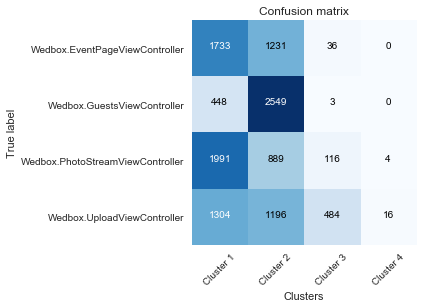

In [41]:
spectre = SpectralClustering(n_clusters=4,random_state=seed).fit(X_scale) # X 9
y_cluster = spectre.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.42950
NMI: 0.13193
Rand Index: 0.10302
Fowlkes–Mallows index: 0.41180


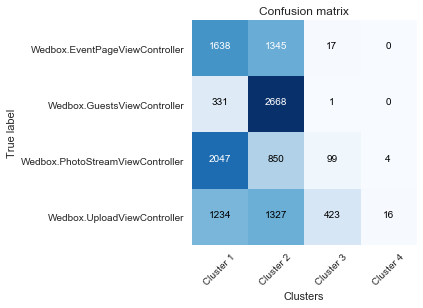

In [44]:
spectre = SpectralClustering(n_clusters=4,random_state=seed).fit(X_scale) # X no other
y_cluster = spectre.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

Confusion matrix, without normalization
Scores:
Purity: 0.46375
AMI: 0.14035
Rand Index: 0.11795
Fowlkes–Mallows index: 0.38673


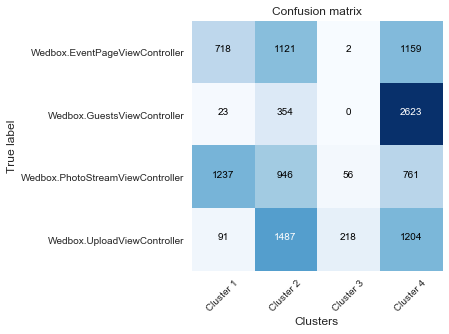

In [23]:
spectre = SpectralClustering(n_clusters=4,random_state=seed, gamma=0.1).fit(X_scale) # X everything
y_cluster = spectre.labels_
plot_confusion_matrix(y_true, y_cluster,classes=le.classes_)

In [245]:
db = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1).fit(X_rd_scale)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=-1, p=None)

In [246]:
y_cluster = db.labels_
distribution_cluster_result(y_cluster)

Number of clusters: 5
Distribution:
 [[  -1  255]
 [   0 7433]
 [   1  299]
 [   2    5]
 [   3    5]
 [   4    3]]


Confusion matrix, without normalization


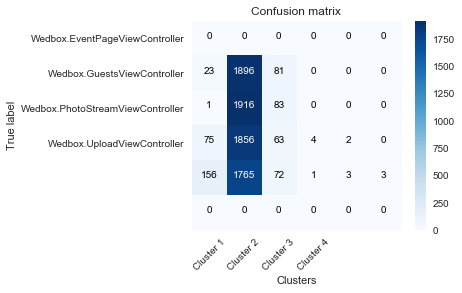

In [247]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_cluster),classes=le.classes_)

In [241]:
print('Scores:')
print('Purity: %.5f' % (purity_score(y_true, y_cluster)))
print('NMI: %.5f' % (normalized_mutual_info_score(y_true, y_cluster)))
print('Rand Index: %.5f' % (adjusted_rand_score(y_true, y_cluster)))
print('Fowlkes–Mallows index: %.5f' % (fowlkes_mallows_score(y_true, y_cluster)))

Scores:
Purity: 0.42488
NMI: 0.11968
Rand Index: 0.10116
Fowlkes–Mallows index: 0.36661


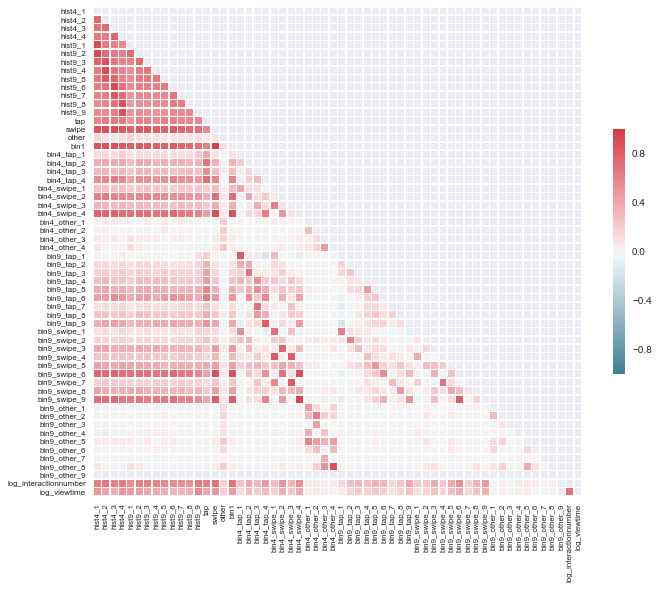

In [40]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Wrapper - SequentialFeatureSelector

In [28]:
kmeans = KMeans(n_clusters=4, random_state=seed)
kf = 10
sfs1 = SFS(kmeans, 
           k_features=kf, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring=make_scorer(purity_score),
           cv=0)

In [29]:
sfs1 = sfs1.fit(X_scale, y_true)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    5.6s finished

[2017-08-31 23:11:07] Features: 1/10 -- score: 0.436416666667[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    6.0s finished

[2017-08-31 23:11:13] Features: 2/10 -- score: 0.483083333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    6.8s finished

[2017-08-31 23:11:20] Features: 3/10 -- score: 0.4875[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    7.0s finished

[2017-08-31 23:11:27] Features: 4/10 -- score: 0.487833333333[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.6s finished

[2017-08-

In [42]:
sfs1.subsets_

{1: {'avg_score': 0.43641666666666667,
  'cv_scores': array([ 0.43641667]),
  'feature_idx': (56,)},
 2: {'avg_score': 0.48308333333333331,
  'cv_scores': array([ 0.48308333]),
  'feature_idx': (56, 29)},
 3: {'avg_score': 0.48749999999999999,
  'cv_scores': array([ 0.4875]),
  'feature_idx': (56, 17, 29)},
 4: {'avg_score': 0.48783333333333334,
  'cv_scores': array([ 0.48783333]),
  'feature_idx': (56, 17, 29, 0)},
 5: {'avg_score': 0.48799999999999999,
  'cv_scores': array([ 0.488]),
  'feature_idx': (0, 33, 17, 56, 29)},
 6: {'avg_score': 0.48866666666666669,
  'cv_scores': array([ 0.48866667]),
  'feature_idx': (0, 33, 8, 17, 56, 29)},
 7: {'avg_score': 0.48899999999999999,
  'cv_scores': array([ 0.489]),
  'feature_idx': (0, 33, 8, 17, 20, 56, 29)},
 8: {'avg_score': 0.48916666666666669,
  'cv_scores': array([ 0.48916667]),
  'feature_idx': (0, 33, 8, 17, 20, 22, 56, 29)},
 9: {'avg_score': 0.48933333333333334,
  'cv_scores': array([ 0.48933333]),
  'feature_idx': (0, 8, 17, 20, 2

In [30]:
feature_index = list(sfs1.k_feature_idx_)
X.iloc[:,feature_index].columns

Index(['hist4_1', 'hist9_5', 'bin4_tap_1', 'bin4_tap_4', 'bin4_swipe_2',
       'bin9_tap_1', 'bin9_tap_5', 'bin9_tap_7', 'bin9_other_4',
       'log_interactionnumber'],
      dtype='object')

In [44]:
feature_index = list(sfs1.subsets_[17]['feature_idx']) # if kf = 20
X.iloc[:,feature_index].columns

Index(['hist4_1', 'hist4_3', 'hist4_4', 'hist9_5', 'bin4_tap_1', 'bin4_tap_3',
       'bin4_tap_4', 'bin4_swipe_2', 'bin4_other_2', 'bin9_tap_1',
       'bin9_tap_5', 'bin9_tap_7', 'bin9_swipe_1', 'bin9_swipe_4',
       'bin9_other_4', 'bin9_other_9', 'log_interactionnumber'],
      dtype='object')

In [28]:
kmeans = KMeans(n_clusters=4, random_state=seed)
kf = 10
sbs = SFS(kmeans, 
           k_features=kf, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring=make_scorer(purity_score),
           cv=0, n_jobs=-1)

In [29]:
sbs = sbs.fit(X_scale, y_true)

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   55.0s finished

[2017-08-28 12:12:44] Features: 57/10 -- score: 0.437[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   42.9s finished

[2017-08-28 12:13:27] Features: 56/10 -- score: 0.438583333333[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   35.6s finished

[2017-08-28 12:14:03] Features: 55/10 -- score: 0.4395[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   33.2s finished

[2017-08-28 12:14:36] Features: 54/10 -- score: 0.4405[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   32.6s finished

[2017-08-28 12:15:09] Features: 53/10 -- score: 0.440833333333[Parallel(n_jobs=-1)]: Done  37 tasks      | 

In [30]:
feature_index = list(sbs.k_feature_idx_)
X.iloc[:,feature_index].columns

Index(['hist4_2', 'bin9_tap_7', 'hist9_2', 'hist9_3', 'hist9_4', 'hist9_5',
       'hist9_6', 'bin4_tap_3', 'bin4_tap_4', 'log_interactionnumber'],
      dtype='object')

In [31]:
kmeans = KMeans(n_clusters=4, random_state=seed)
kf = 10
sfsf = SFS(kmeans, 
           k_features=kf, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring=make_scorer(purity_score),
           cv=0, n_jobs=-1)

In [32]:
sfsf = sfsf.fit(X_scale, y_true)

[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    6.0s finished

[2017-08-31 23:18:12] Features: 1/10 -- score: 0.436416666667[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2017-08-31 23:18:19] Features: 2/10 -- score: 0.483083333333[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished

[2017-08-31 23:18:27] Features: 3/10 -- score: 0.4875[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished

[2017-08-31 23:18:36] Features: 4/10 -- score: 0.48783333

In [33]:
feature_index = list(sfsf.k_feature_idx_)
X.iloc[:,feature_index].columns

Index(['hist4_1', 'hist9_5', 'bin4_tap_1', 'bin4_tap_4', 'bin4_swipe_2',
       'bin9_tap_1', 'bin9_tap_5', 'bin9_tap_7', 'bin9_other_4',
       'log_interactionnumber'],
      dtype='object')

In [36]:
kmeans = KMeans(n_clusters=4, random_state=seed)
kf = 10
sbsf = SFS(kmeans, 
           k_features=kf, 
           forward=False, 
           floating=True, 
           verbose=2,
           scoring=make_scorer(purity_score),
           cv=0, n_jobs=-1)

In [37]:
sbsf.fit(X_scale, y_true)

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   49.7s finished

[2017-08-31 23:37:26] Features: 57/10 -- score: 0.437[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   33.6s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished

[2017-08-31 23:38:01] Features: 56/10 -- score: 0.438583333333[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s finished

[2017-08-31 23:38:36] Features: 55/10 -- score: 0.4395[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished

[2017-08-31 23:39:08] Features: 55/10 -- score: 0.441333333333[Parallel(n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   11.1s finished

[2017-08-31 23:53:46] Features: 29/10 -- score: 0.44475[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   12.0s finished

[2017-08-31 23:54:10] Features: 28/10 -- score: 0.444583333333[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.4s finished

[2017-08-31 23:54:33] Features: 28/10 -- score: 0.444666666667[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.3s finished

[2017-08-31 23:54:56] Features: 27/10 -- score: 0.444583333333[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   11.7s finished

[2017-08-31 23:55:19] Features: 27/10 -- score: 0.443916666667[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:

[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   12.0s finished

[2017-09-01 00:06:09] Features: 15/10 -- score: 0.473333333333[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   12.3s finished

[2017-09-01 00:06:26] Features: 15/10 -- score: 0.486166666667[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.2s finished

[2017-09-01 00:06:30] Features: 14/10 -- score: 0.47325[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.6s finished

[2017-09-01 00:06:34] Features: 13/10 -- score: 0.473083333333[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.1s finished

[2017-09-01 00:06:49] Features: 12/10 -- score: 0.49025[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished
[Parall

SequentialFeatureSelector(clone_estimator=True, cv=0,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1437, tol=0.0001, verbose=0),
             floating=True, forward=False, k_features=10, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring=make_scorer(purity_score),
             skip_if_stuck=True, verbose=2)

In [38]:
feature_index = list(sbsf.k_feature_idx_)
X.iloc[:,feature_index].columns

Index(['bin9_tap_4', 'hist4_4', 'bin9_tap_9', 'bin9_swipe_1', 'hist9_5',
       'swipe', 'bin1', 'bin4_tap_1', 'log_interactionnumber', 'bin9_tap_1'],
      dtype='object')

In [44]:
metric_dict = sbsf.get_metric_dict()
ft = []
sc = []
for key, value in metric_dict.items():
    ft.append(key)
    sc.append(value['avg_score'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
ft = np.array(ft)
sc = np.array(sc)

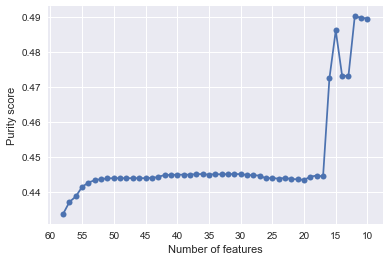

In [62]:
plt.plot(ft, sc, marker='.', markersize=12)
plt.xlabel('Number of features')
plt.xticks(np.arange(60,5,-5))
plt.ylabel('Purity score')
ax = plt.gca()
ax.invert_xaxis()

In [17]:
spectral = SpectralClustering(n_clusters=4, random_state=seed)
kf = 2
sfs = SFS(spectral, 
           k_features=kf, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring=make_scorer(purity_score),
           cv=0)

In [19]:
sfs.fit(X_scale, y_true) # doenst work

AttributeError: 'SpectralClustering' object has no attribute 'predict'

**Supervised**

In [24]:
param = {'max_depth': [6,8,10,12,15,20,30],
         'n_estimators': [60, 80, 100, 120, 150, 200, 300]}
rf = RandomForestClassifier(random_state = seed, oob_score=True) # X simple
grid_s = GridSearchCV(rf, param)
grid_s.fit(X_scale, y_true)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=1437,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [6, 8, 10, 12, 15, 20, 30], 'n_estimators': [60, 80, 100, 120, 150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [26]:
grid_s.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [27]:
grid_s.best_score_

0.66208333333333336

In [28]:
rf = RandomForestClassifier(max_depth=12, n_estimators=300, random_state = seed, oob_score=True)
rf.fit(X_scale,y_true)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=True, random_state=1437,
            verbose=0, warm_start=False)

In [29]:
rf.oob_score_

0.67166666666666663

In [30]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col = X.columns
for f in range(X_scale.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature log_viewtime (0.205790)
2. feature bin1 (0.099358)
3. feature log_interactionnumber (0.097845)
4. feature bin4_tap_1 (0.074645)
5. feature bin4_tap_4 (0.067115)
6. feature bin4_swipe_4 (0.061668)
7. feature bin4_tap_3 (0.059839)
8. feature hist4_1 (0.049883)
9. feature bin4_swipe_1 (0.049586)
10. feature hist4_4 (0.046729)
11. feature hist4_2 (0.043169)
12. feature bin4_tap_2 (0.039088)
13. feature hist4_3 (0.036039)
14. feature bin4_swipe_3 (0.035161)
15. feature bin4_swipe_2 (0.034087)


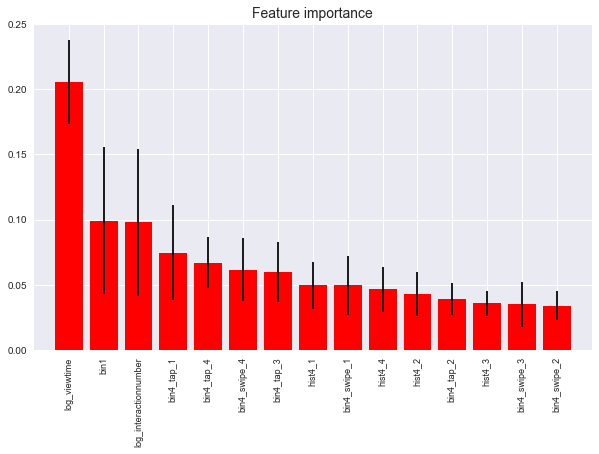

In [31]:
# Plot the feature importances of the forest
plt.figure(figsize=[10,6])
plt.title('Feature importance', fontsize=14)
plt.bar(range(X_scale.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_scale.shape[1]), [col[k] for k in indices], fontsize=9, rotation=90)
plt.xlim([-1, X_scale.shape[1]])
plt.show()

In [17]:
param = {'max_depth': [6,8,10,12,15,20,30],
         'n_estimators': [60, 80, 100, 120, 150, 200, 300]}
rf = RandomForestClassifier(random_state = seed, oob_score=True) # X everything
grid = GridSearchCV(rf, param)
grid.fit(X_scale, y_true)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=1437,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [6, 8, 10, 12, 15, 20, 30], 'n_estimators': [60, 80, 100, 120, 150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
grid.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [25]:
grid.best_score_

0.69816666666666671

In [17]:
rf = RandomForestClassifier(max_depth=15, n_estimators=300, random_state = seed, oob_score=True)
rf.fit(X_scale,y_true)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=True, random_state=1437,
            verbose=0, warm_start=False)

In [18]:
rf.oob_score_

0.70691666666666664

In [22]:
y_pred = grid.predict(X_scale)

Confusion matrix, without normalization
Scores:
Purity: 0.90058
AMI: 0.70545
Rand Index: 0.75421
Fowlkes–Mallows index: 0.81574


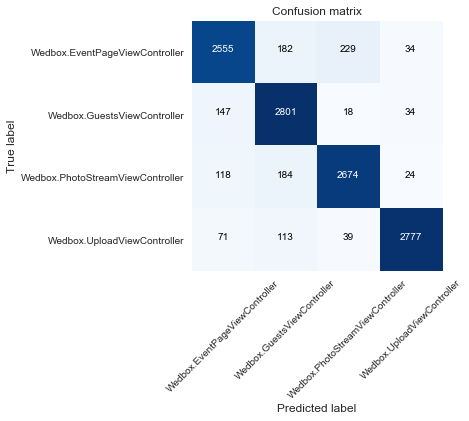

In [24]:
plot_confusion_matrix(y_true, y_pred, le.classes_, type='classification')

In [19]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col = X.columns
for f in range(X_scale.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature log_viewtime (0.141940)
2. feature bin1 (0.051895)
3. feature log_interactionnumber (0.050863)
4. feature tap (0.044370)
5. feature swipe (0.041348)
6. feature bin9_tap_1 (0.034510)
7. feature bin9_tap_9 (0.031530)
8. feature bin9_tap_7 (0.030430)
9. feature bin4_tap_1 (0.029382)
10. feature bin4_swipe_4 (0.028949)
11. feature hist4_1 (0.026301)
12. feature hist4_4 (0.025258)
13. feature bin4_tap_4 (0.025149)
14. feature bin9_swipe_1 (0.022582)
15. feature hist4_2 (0.021910)
16. feature bin4_tap_3 (0.021446)
17. feature bin4_swipe_1 (0.020669)
18. feature bin9_swipe_9 (0.019338)
19. feature hist4_3 (0.018596)
20. feature bin4_swipe_2 (0.017892)
21. feature bin9_swipe_7 (0.017137)
22. feature bin9_swipe_6 (0.016928)
23. feature hist9_9 (0.016799)
24. feature bin4_tap_2 (0.015810)
25. feature hist9_3 (0.015750)
26. feature bin4_swipe_3 (0.014166)
27. feature hist9_2 (0.014067)
28. feature hist9_7 (0.014008)
29. feature hist9_8 (0.013726)
30. feature hist9_1 (0

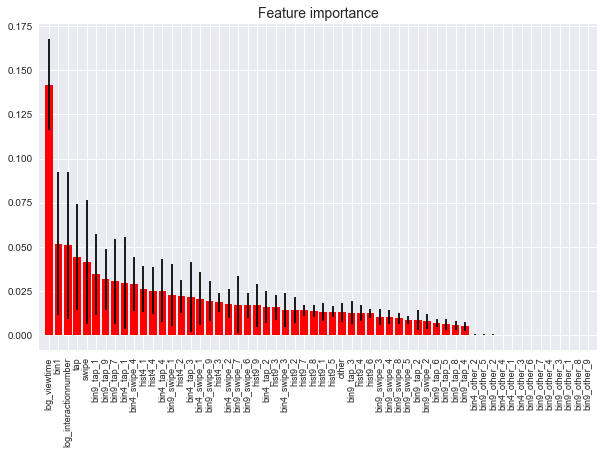

In [20]:
# Plot the feature importances of the forest
plt.figure(figsize=[10,6])
plt.title('Feature importance', fontsize=14)
plt.bar(range(X_scale.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_scale.shape[1]), [col[k] for k in indices], fontsize=9, rotation=90)
plt.xlim([-1, X_scale.shape[1]])
plt.show()

In [30]:
max = 0
for idx, value in sfs.subsets_.items():
    if value['avg_score'] > max:
        max = value['avg_score']
max

0.69908333333333339

In [32]:
for idx, value in sfs.subsets_.items():
    if value['avg_score'] == max:
        print(idx)
        # print(value['features'])

27


In [ ]:
rf = RandomForestClassifier(max_depth = 15, n_estimators = 300, random_state = seed, oob_score=True)
sbs = SFS(rf, 
           k_features=1, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=4)

In [35]:
max = 0
for idx, value in sffs.subsets_.items():
    if value['avg_score'] > max:
        max = value['avg_score']
max

0.69866666666666677

In [33]:
from sklearn.linear_model import LogisticRegression
mnlogreg = LogisticRegression(solver='newton-cg', random_state=seed, multi_class='multinomial')

In [37]:
# Using only data that removes colinearity
X_col = scaler.fit_transform(X_col)
X_col.shape

(8000, 27)

In [38]:
mnlogreg.fit(X_col, y_true)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1437, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
coef_df = pd.DataFrame(mnlogreg.coef_, columns=columns_name_colinearity, index=le.classes_)
coef_df

,hist1,hist4_1,hist4_2,hist4_3,hist9_1,hist9_2,hist9_3,hist9_4,hist9_5,hist9_6,...,bin4_3,bin9_1,bin9_2,bin9_3,bin9_4,bin9_5,bin9_6,bin9_7,bin9_8,viewtime
EventPageViewController,1.057489,-0.367763,-0.135711,-0.157466,-0.762822,-0.463558,0.158424,-0.613925,0.039641,-0.400838,...,0.456853,-0.329551,-0.387463,-1.902953,0.327925,-0.397841,0.329622,1.862411,1.026152,0.689364
GuestsViewController,-4.861768,-3.198665,-2.905871,-0.956182,-2.744955,-3.558460,-3.642428,-2.396871,-1.308693,-0.712920,...,-2.527963,0.490694,-4.137818,-0.117689,-0.294247,-1.121466,-0.765518,-5.193325,-0.739729,-3.881985
PhotoStreamViewController,1.798547,1.136530,0.670341,0.236366,1.595233,0.860918,0.856159,1.184459,-0.565098,0.714175,...,0.544820,7.320678,2.823909,3.142017,-0.788639,0.988985,0.523850,-2.595371,1.866326,3.364119
UploadViewController,2.005732,2.429897,2.371240,0.877282,1.912543,3.161100,2.627845,1.826337,1.834151,0.399583,...,1.526290,-7.481821,1.701373,-1.121376,0.754960,0.530322,-0.087954,5.926285,-2.152749,-0.171498


In [47]:
mnlogreg_ovr = LogisticRegression(solver='newton-cg', random_state=seed, multi_class='ovr')
mnlogreg_ovr.fit(X_col, y_true)
coef_ovr_df = pd.DataFrame(mnlogreg_ovr.coef_, columns=columns_name_colinearity, index=le.classes_)
coef_ovr_df

,hist1,hist4_1,hist4_2,hist4_3,hist9_1,hist9_2,hist9_3,hist9_4,hist9_5,hist9_6,...,bin4_3,bin9_1,bin9_2,bin9_3,bin9_4,bin9_5,bin9_6,bin9_7,bin9_8,viewtime
EventPageViewController,0.142844,-1.412528,-1.057411,-0.908008,-1.815092,-1.569409,-0.799057,-1.447861,-0.714580,-1.134293,...,-0.662446,-0.546476,-1.132013,-2.058064,-0.044786,-1.098034,-0.115130,0.581449,0.855651,0.018862
GuestsViewController,-5.570151,-3.884365,-3.486819,-1.249181,-3.421731,-4.301817,-4.301327,-2.857567,-1.685475,-0.931745,...,-2.950458,0.188131,-5.172711,-0.345162,-0.386995,-1.407413,-0.963643,-5.819478,-0.839098,-4.417102
PhotoStreamViewController,0.773049,-0.106276,-0.627612,-0.505751,0.711712,-0.841307,-0.511870,0.117829,-1.516272,0.140213,...,-0.643838,8.879030,2.985916,3.269598,-1.026001,-0.114523,-0.425398,-3.963999,1.571476,3.661987
UploadViewController,1.337635,1.695589,1.976122,0.557577,0.771395,2.794065,2.241355,1.297220,1.870058,-0.053599,...,1.152737,-9.229042,0.719096,-2.135509,0.322626,-0.810348,-0.010082,6.284835,-3.220079,-0.770537


In [256]:
from sklearn.svm import SVC

In [257]:
svc = SVC(C=0.01, kernel='rbf', random_state=seed)

In [283]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [279]:
train, test, y_train, y_test = train_test_split(X_rd_scale, y_true, test_size=0.2, random_state=seed, stratify=y_true)

In [284]:
parameters = {'kernel':('rbf','poly'), 'C':[0.01,0.1,1,10], 'gamma':[0.01,0.1,1,10]}

In [286]:
svc = SVC()
grid = GridSearchCV(svc, parameters)
grid.fit(train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ('rbf', 'poly')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [296]:
grid.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ('rbf', 'poly')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)>

In [288]:
grid.score(test,y_test)

0.56999999999999995

## Testing on 3 different users, all screens

In [55]:
user_sample_index = df_vq.user_id.value_counts().head(3).index

In [57]:
number_row = 300
df_1 = df_vq[df_vq.user_id == user_sample_index[0]].sample(n=number_row, random_state=seed)
df_2 = df_vq[df_vq.user_id == user_sample_index[1]].sample(n=number_row, random_state=seed)
df_3 = df_vq[df_vq.user_id == user_sample_index[2]].sample(n=number_row, random_state=seed)
df_user = pd.concat([df_1, df_2, df_3])
len(df_user)

900

In [59]:
y_user = df_user['user_id']
le = LabelEncoder()
y_user_true = le.fit_transform(y_user)
y_user_true.shape

(900,)

In [60]:
columns_simple = ['hist4_1','hist4_2','hist4_3','hist4_4',
                  'bin1','bin4_tap_1','bin4_tap_2','bin4_tap_3','bin4_tap_4','bin4_swipe_1','bin4_swipe_2',
                  'bin4_swipe_3','bin4_swipe_4',
                  'log_interactionnumber','log_viewtime']
X_user = df_user[columns_simple]

In [61]:
scaler = MinMaxScaler()
X_user_scale = scaler.fit_transform(X_user)
X_user_scale.shape

(900, 15)

Confusion matrix, without normalization
Scores:
Purity: 0.40444
NMI: 0.02729
Rand Index: 0.01600
Fowlkes–Mallows index: 0.45710


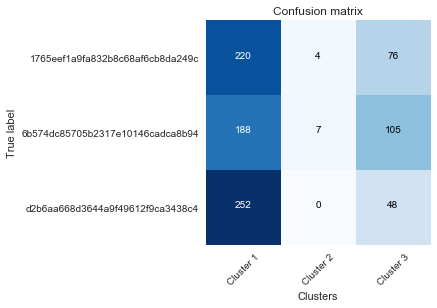

In [63]:
kmeans = KMeans(n_clusters=3, random_state=seed).fit(X_user_scale) # X user simple
y_user_cluster = kmeans.labels_
plot_confusion_matrix(y_user_true, y_user_cluster,classes=le.classes_)

# EXPERIMENT ON SEQUENCE: DTW AND LEVENSHTEIN

In [69]:
dynamic_time_warp([0,1,0,1,0,1],[1,0,1,0,1,0])[0]

1.4142135623730951

In [63]:
dynamic_time_warp([0,1,0,1,0,1],[1,1,1,0,1,0])[0]

1.4142135623730951

In [64]:
dynamic_time_warp([0,1,0,1,0,1],[1,1,1,0,1,1])[0]

1.4142135623730951

In [65]:
dynamic_time_warp([0,1,0,1,0,1],[1,1,1,1,1,1])[0]

1.7320508075688772

In [68]:
dynamic_time_warp([0,1,0,1,0,1],[0,1,0,1,0,1,0])[0]

1.0

# TOY DATA

In [139]:
df_3 = df_seq[df_seq.screen == 'GuestsViewController'].iloc[0:number_row,:]
df_5 = df_seq[(df_seq.screen == 'UploadViewController') & (df_seq.hist_length > 20)].iloc[0:number_row,:]

In [140]:
df_toy = pd.concat([df_3, df_5])
len(df_toy)

751

In [132]:
df_2.hist_length.describe()

count    400.000000
mean      14.440000
std       20.469585
min        2.000000
25%        3.000000
50%        7.000000
75%       15.000000
max      160.000000
Name: hist_length, dtype: float64

In [133]:
np.percentile(df_2.hist_length,90)

37.0

In [146]:
X_toy = df_toy[['log_hist_length', 'log_interaction_number']] # trail_number, tap_number
print(X_toy.shape)
y_toy_true = number_row * [0] + 351 * [1]
y_toy_true = np.array(y_toy_true)
y_toy_true.shape

(751, 2)


(751,)

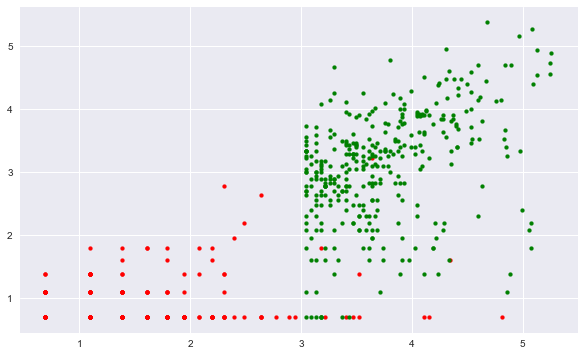

In [147]:
fig = plt.figure(figsize=[10,6])
plt.scatter(x=np.log(df_3.hist_length), y=np.log(df_3.interaction_number), c='red', s=15)
plt.scatter(x=np.log(df_5.hist_length), y=np.log(df_5.interaction_number), c='green', s=15)

In [150]:
kmeans_toy = KMeans(n_clusters=2, random_state=seed).fit(X_toy)

In [151]:
y_toy_cluster = kmeans_toy.labels_
print('Scores:')
print('Purity: %.5f' % (purity_score(y_toy_true, y_toy_cluster)))
print('NMI: %.5f' % (normalized_mutual_info_score(y_toy_true, y_toy_cluster)))
print('Rand Index: %.5f' % (adjusted_rand_score(y_toy_true, y_toy_cluster)))
print('Fowlkes–Mallows index: %.5f' % (fowlkes_mallows_score(y_toy_true, y_toy_cluster)))
confusion_matrix(y_toy_true, y_toy_cluster)

Scores:
Purity: 0.97337
NMI: 0.82233
Rand Index: 0.89617
Fowlkes–Mallows index: 0.94824


array([[ 10, 390],
       [341,  10]])